In [24]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Product_data.csv')

In [4]:
print(df.head())

     everyday productid                 productname  quantity
0  2023-08-16   D_10006                CURD - 200 G      60.0
1  2023-08-16   D_10029  STANDARDISED MILK - 500 ml      48.0
2  2023-08-16   D_10006                CURD - 200 G      60.0
3  2023-08-16   D_10017  DOUBLE TONED MILK - 500 ml      72.0
4  2023-08-16   D_10033         TONED MILK - 500 ml      24.0


In [5]:
df.shape

(2516944, 4)

In [6]:
# Filter for product ID D_10006
df_filtered = df[df['productid'] == 'D_10006']

# Group by date and sum quantity
df_grouped = df_filtered.groupby('everyday')['quantity'].sum().reset_index()

#everyday datatype changed into datetime
df_grouped['everyday'] = pd.to_datetime(df_grouped['everyday'])

In [7]:
# Set 'date' column as the index
df_grouped.set_index('everyday', inplace=True)

In [8]:
print(df_grouped)

            quantity
everyday            
2022-10-01    8760.0
2022-10-02    9720.0
2022-10-03   11820.0
2022-10-04   12720.0
2022-10-05   11880.0
...              ...
2023-08-17    8580.0
2023-08-18    7380.0
2023-08-19    6720.0
2023-08-20    8100.0
2023-08-21    7860.0

[324 rows x 1 columns]


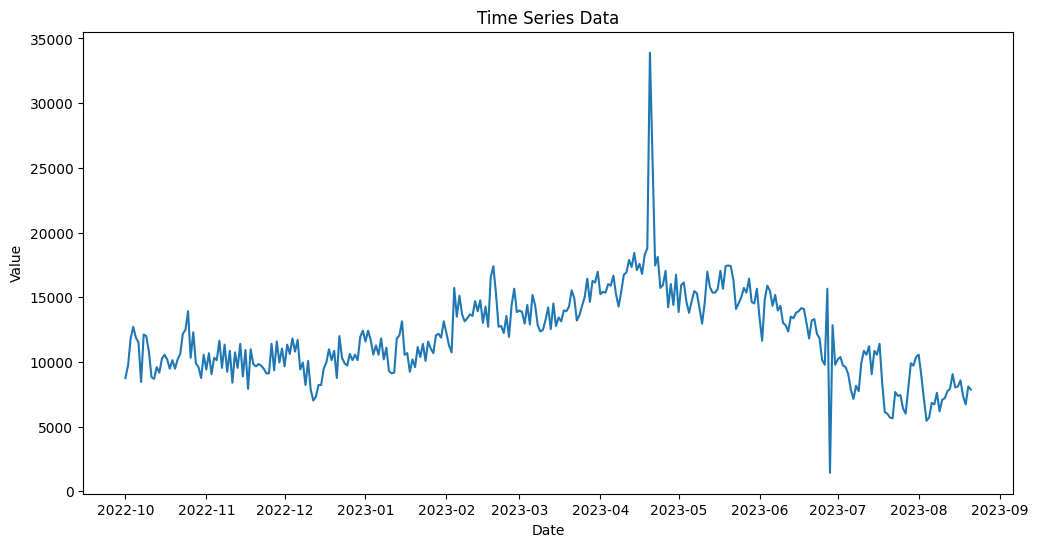

In [9]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(df_grouped['quantity'])
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [10]:
df_grouped.shape

(324, 1)

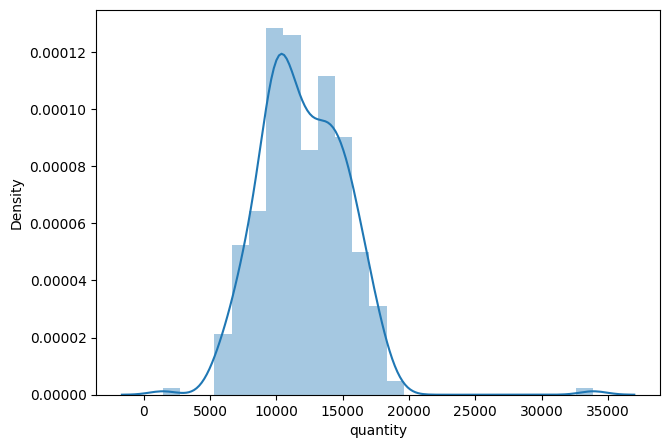

In [11]:
#detecting outlier in Quantity Columns Using Z Score Technique
plt.figure(figsize=(16,5))
plt.subplot(1,2,2)
sns.distplot(df_grouped['quantity'])
plt.show()

In [12]:
df_grouped['quantity'].skew()

0.8555494440417836

In [13]:
print("Mean vlaue of Quantity", df_grouped['quantity'].mean())
print("Std vlaue of Quantity", df_grouped['quantity'].std())
print("Min vlaue of Quantity", df_grouped['quantity'].min())
print("Max vlaue of Quantity", df_grouped['quantity'].max())

Mean vlaue of Quantity 12007.962962962964
Std vlaue of Quantity 3266.491786772356
Min vlaue of Quantity 1440.0
Max vlaue of Quantity 33900.0


In [14]:
# Finding the boundary values
print("Highest allowed", df_grouped['quantity'].mean() + 3*df_grouped['quantity'].std())
print("Lowest allowed", df_grouped['quantity'].mean() - 3*df_grouped['quantity'].std())

Highest allowed 21807.438323280032
Lowest allowed 2208.487602645895


In [15]:
# Finding the outliers
df_grouped[(df_grouped['quantity'] > 21807.43) | (df_grouped['quantity'] < 2208.48)]

,quantity
everyday,
2023-04-20,33900.0
2023-06-28,1440.0


In [16]:
new_df = df_grouped[(df_grouped['quantity'] < 21807.43) & (df_grouped['quantity'] > 2208.48)]
new_df

,quantity
everyday,
2022-10-01,8760.0
2022-10-02,9720.0
2022-10-03,11820.0
2022-10-04,12720.0
2022-10-05,11880.0
...,...
2023-08-17,8580.0
2023-08-18,7380.0
2023-08-19,6720.0


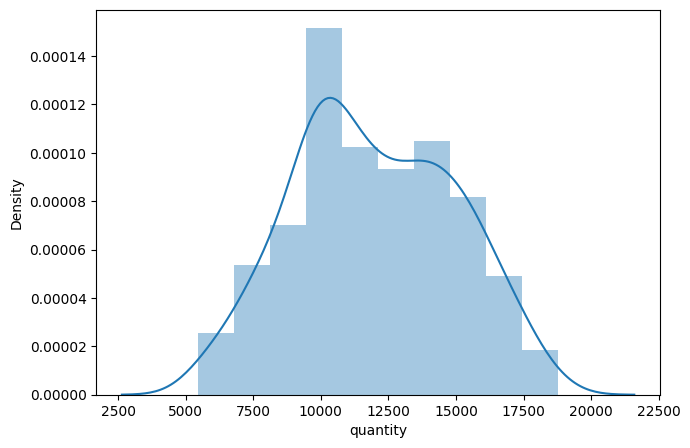

In [17]:
# Plot the time series data
plt.figure(figsize=(16,5))
plt.subplot(1,2,2)
sns.distplot(new_df['quantity'])
plt.show()

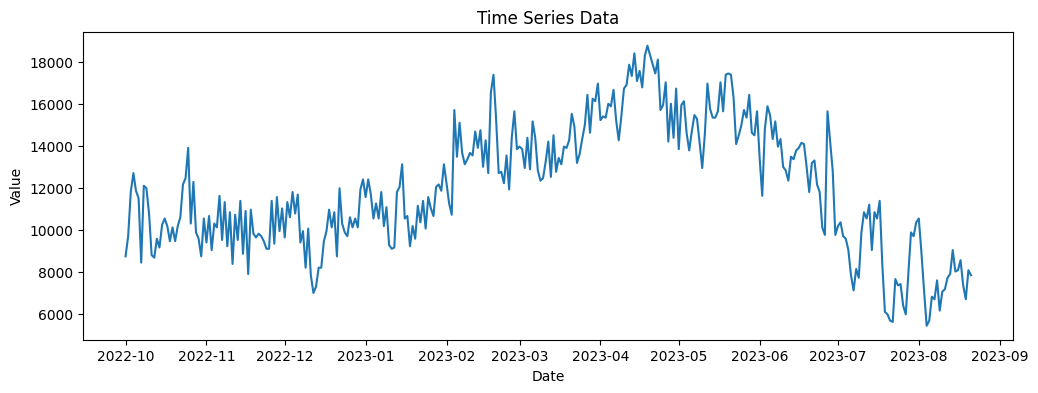

In [18]:
# Plot the time series data
plt.figure(figsize=(12, 4))
plt.plot(new_df['quantity'])
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [19]:
# Time-based train-test split
split_index = int(len(new_df) * 0.8)
train, test = new_df.iloc[:split_index], new_df.iloc[split_index:]

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [21]:
# Fit the Exponential Smoothing model
model = ExponentialSmoothing(train["quantity"], trend="add", seasonal="add", seasonal_periods=11)
model_fit = model.fit()

In [22]:
# Generate predictions
predictions = model_fit.forecast(steps=len(test))

In [25]:
# Evaluate model performance
mse = mean_squared_error(test["quantity"], predictions)
mae = mean_absolute_error(test["quantity"], predictions)
evs = explained_variance_score(test["quantity"], predictions)
print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, Exp. Var. Score: {evs:.2f}")

MSE: 17559125.21, MAE: 3739.98, Exp. Var. Score: 0.24


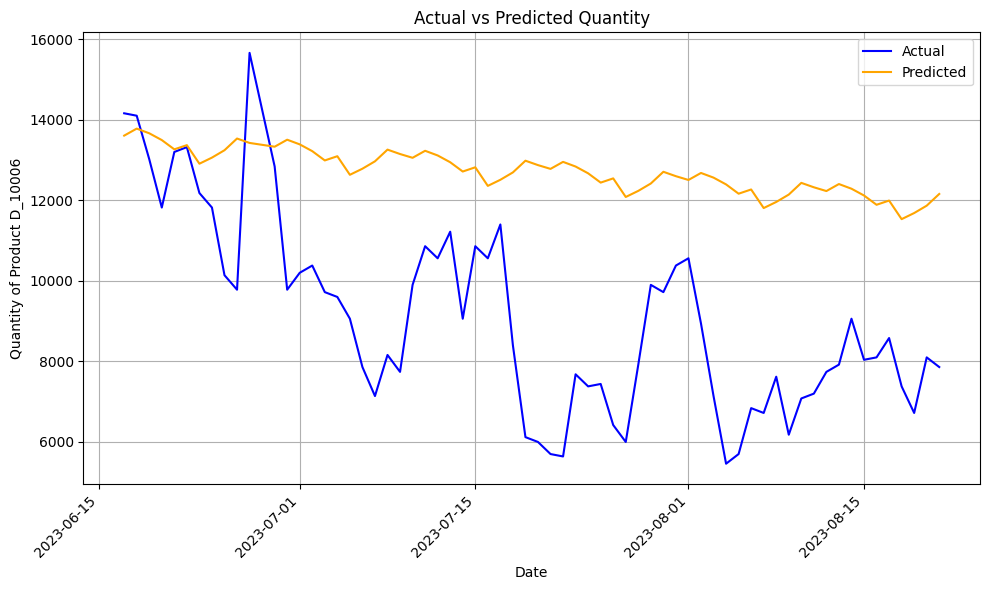

In [27]:
# Assuming predictions is aligned with the testing set's index

plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Plot actual values (blue line)
plt.plot(test.index, test['quantity'], label='Actual', color='blue')

# Plot predictions on the testing set (orange line)
plt.plot(test.index, predictions, label='Predicted', color='orange')

# Customize the graph
plt.xlabel('Date')
plt.ylabel('Quantity of Product D_10006')
plt.title('Actual vs Predicted Quantity')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.legend()  # Add legend to distinguish lines
plt.grid(True)

# Show the graph
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [28]:
# Future forecasting:
future_forecast = model_fit.forecast(steps=30)  # Predict for the next 5 days
print("Future Forecast:\n", future_forecast)

Future Forecast:
 257    13605.606049
258    13779.626646
259    13663.673592
260    13495.278640
261    13264.803442
262    13369.485526
263    12908.288146
264    13059.626796
265    13242.795885
266    13533.427909
267    13423.991862
268    13330.367444
269    13504.388040
270    13388.434986
271    13220.040034
272    12989.564836
273    13094.246921
274    12633.049540
275    12784.388191
276    12967.557279
277    13258.189304
278    13148.753256
279    13055.128838
280    13229.149435
281    13113.196381
282    12944.801429
283    12714.326231
284    12819.008315
285    12357.810934
286    12509.149585
dtype: float64
